In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LeakyReLU, LSTM
from tensorflow.keras.optimizers import Adam
from scipy.stats import norm
from scipy.linalg import svd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os 

# Fetch stock data from Yahoo Finance
def fetch_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Compute technical indicators
def compute_technical_indicators(data):
    data['SMA30'] = data['Close'].rolling(window=30).mean()
    data['SMA100'] = data['Close'].rolling(window=100).mean()
    vol_window = 30
    data['Volatility'] = data['Close'].pct_change().rolling(window=vol_window).std() * np.sqrt(252)
    return data.dropna()

# Black-Scholes option pricing model
def black_scholes(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Apply Black-Scholes model to generate option prices
def add_option_pricing_features(data):
    strike_price = data['Close'] * 1.05
    time_to_maturity = 30 / 252
    risk_free_rate = 0.01
    option_type = 'call'
    data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
    data['Implied_Volatility'] = data['Volatility']
    return data

# Normalize and apply PCA for dimensionality reduction
def preprocess_data(data, n_pca_components=2):
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    # pca = PCA(n_components=n_pca_components)
    # data_pca = pca.fit_transform(data_scaled)
    # return np.hstack((data_scaled, data_pca))
    return data_scaled, scaler

# Create sequences for time-series prediction
def create_sequences(data, seq_len, pred_len):
    sequences = []
    for i in range(len(data) - seq_len - pred_len + 1):
        sequences.append(data[i:i + seq_len + pred_len])
    return np.array(sequences)

# Function to create a Hankel matrix
def create_hankel_matrix(time_series, window_size):
    # Create a Hankel matrix where the columns are shifted versions of the time series
    hankel_matrix = np.array([time_series[i:i + window_size] for i in range(len(time_series) - window_size + 1)])
    return hankel_matrix

# Function to perform SVD on the Hankel matrix
def hankel_svd(hankel_matrix):
    # Perform SVD on the Hankel matrix
    U, Sigma, Vt = svd(hankel_matrix, full_matrices=False)
    return U, Sigma, Vt

# Build a neural network model
def build_model(input_shape, output_len):
    model = Sequential([
    LSTM(180, activation='relu', return_sequences=False),  # LSTM layer
    Dense(180),
    LeakyReLU(),
    Dense(360),
    LeakyReLU(),
    Dense(360),
    LeakyReLU(),
    Dense(output_len)  # Output predictions for "Close" prices
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model



def predict_and_plot(m, ticker, data, s, model, seq_len, pred_len, scaler, cut_off):
    plt.figure(figsize=(14, 7))

    rmse_values = []  # To store RMSE values for each section
    section_start_idx = []  # To store the start indices of each 30-day section for placement of RMSE labels
    #s.shape[0]
    for idx in range(0,cut_off+pred_len , pred_len):  # Loop through each 30-day block
    # for idx in range(1): # only first 30 after being trained
        # Input remains in 3D for predictio
        future_input = s[idx, :seq_len, :].reshape(1, seq_len, -1)  # Keep the 3D shape
        future = model.predict(future_input)[0]  # Predict future "Close" prices
        # Pad the prediction with zeros for the "Volume" and "SMA" columns
        future_padded = np.hstack((future.reshape(-1, 1), np.zeros((future.shape[0], data.shape[1] - 3))))  # Adjust for PCA features

        # Inverse transform the padded prediction
        future_transform = scaler.inverse_transform(future_padded)[:, 0]  # Extract "Close"

        # Extract and inverse transform the true "Close" values
        future_true = s[idx, seq_len:, 0].reshape(-1, 1)  # Use only "Close"
        future_true_padded = np.hstack((future_true, np.zeros((future_true.shape[0], data.shape[1] - 3))))  # Adjust for PCA features
        future_true_transform = scaler.inverse_transform(future_true_padded)[:, 0]  # Extract "Close"

        # Calculate RMSE for this 30-day section
        percent_error = np.mean(np.abs((future_true_transform - future_transform) / future_true_transform)) * 100
        rmse_values.append(percent_error)
        section_start_idx.append(idx)  # Store the start index for the percentage error label


        # Plot the predictions
        plt.plot(np.arange(idx, idx + pred_len), future_transform, 
                # label="Train Prediction" if idx < cut_off else "Test Prediction", 
                 color="red" if idx < cut_off else "blue")

        # Plot the true values
        plt.plot(np.arange(idx, idx + pred_len), future_true_transform, 
                 #label="Train True" if idx < cut_off else "Test True", 
                 color="black" if idx < cut_off else "green")

        
    
    # Add legend and grid
    # plt.legend(["Train Prediction", "Train True", "Test Prediction", "Test True"])
    plt.plot([], [], color="red", label="Train Prediction")  # Dummy plot for legend
    plt.plot([], [], color="black", label="Train True")      # Dummy plot for legend
    plt.plot([], [], color="blue", label="Test Prediction")  # Dummy plot for legend
    plt.plot([], [], color="green", label="Test True")      # Dummy plot for legend
    plt.legend()
    for idx in range(0, s.shape[0], pred_len): 
    # Add vertical line to separate each 30-day section
        plt.axvline(x=idx + pred_len, color='gray', linestyle='--', linewidth=1)
    # Title and labels
    
    plt.title(f"{seq_len}-{pred_len} Predictions for {ticker}, model {m}")
    plt.xlabel("Trading Days")
    plt.ylabel("Price")

    # Add RMSE labels below the x-axis at the start of each 30-day section
    for i, rmse in zip(section_start_idx, rmse_values):
        plt.text(i + pred_len / 2, min(plt.ylim()), f"{rmse:.0f}", color="teal", fontsize=10, ha='center', va='top')
    plt.text(- 5- pred_len / 2, min(plt.ylim()), f"MAPE:", color="teal", fontsize=10, ha='center', va='top')
    print(rmse_values)
    plt.grid(True)
    if m == "LSTM w/ 7 features":
        dir = f"{seq_len}-{pred_len}/lstm_7"
        if not os.path.exists(dir):
                os.makedirs(dir)
        plt.savefig(f"{dir}/{ticker}.png")
    return rmse_values[-1] # testing rmse

    # plt.show()

# Call the function


# Main workflow
def main(tickers):
    m = "LSTM w/ 7 features"
    test_rmse = []
    for ticker in tickers:
        # Step 1: Fetch data
        tsla = fetch_stock_data(ticker, start_date="2021-01-01", end_date="2024-09-30")

        # Step 2: Compute indicators
        tsla = compute_technical_indicators(tsla)

        # Step 3: Add Black-Scholes option pricing
        tsla = add_option_pricing_features(tsla)

        # Step 4: Prepare data for training
        features = ['Close', 'Volume', 'SMA30', 'SMA100', 'Volatility']
        data = tsla[features].copy()
        # Step 5: Perform Hankel Matrix Decomposition
        window_size = 20  # Size of the sliding window to form the Hankel matrix
        hankel_matrix = create_hankel_matrix(data['Close'].values, window_size)

        # Step 6: Perform SVD on the Hankel matrix
        U, Sigma, Vt = hankel_svd(hankel_matrix)

        # You can choose the first few singular values and modes to add as features
        num_modes = 2  # Number of modes to add as features
        dmd_modes = U[:, :num_modes]  # Select the modes
        dmd_amplitudes = Sigma[:num_modes]  # Select the amplitudes

        # Step 7: Normalize and apply PCA for dimensionality reduction
        processed_data,scaler = preprocess_data(data)

        # Trim the processed_data to match the number of rows in dmd_modes
        processed_data_trimmed = processed_data[-dmd_modes.shape[0]:]  # Trim to match the length of dmd_modes

        # Combine the Hankel decomposition modes with the processed data
        data_combined = np.hstack((processed_data_trimmed, dmd_modes))

        # Step 8: Create sequences for time-series prediction
        seq_len = 6 * 30  # 6 months of data
        pred_len = 20  # Predict the next 20 days
        sequences = create_sequences(data_combined, seq_len, pred_len)

        # Step 9: Split data into training and testing
        cut_off = int(0.95 * sequences.shape[0])
        X_train = sequences[:cut_off, :seq_len, :]
        X_test = sequences[cut_off:, :seq_len, :]
        y_train = sequences[:cut_off, seq_len:, 0]
        y_test = sequences[cut_off:, seq_len:, 0]
        print(sequences.shape)
        
        # Step 10: Build and train the model
        model = build_model(input_shape=(seq_len, X_train.shape[2]), output_len=pred_len)
        history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=32,
            verbose=1
        )

        test_rmse += [predict_and_plot(m, ticker, data_combined, sequences, model, seq_len, pred_len, scaler, cut_off)]

    mse_for_model  = np.mean(test_rmse)
    return mse_for_model

2024-12-01 15:47:51.379995: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_7024/1809001411.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
/tmp/ipykernel_7024/1809001411.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Implied_Volatility'] = data['Volatility']
2024-12-01 15:47:57.087765: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] 

(593, 200, 7)
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - loss: 0.0810
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0123
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0091
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0077
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0070
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0058
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0054
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0049
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0047
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0042
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0037
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0039
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0032
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0030
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━

[*********************100%***********************]  1 of 1 completed

(593, 200, 7)
Epoch 1/100



/tmp/ipykernel_7024/1809001411.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
/tmp/ipykernel_7024/1809001411.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Implied_Volatility'] = data['Volatility']


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - loss: 0.0863
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - loss: 0.0057
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 0.0040
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 0.0035
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - loss: 0.0033
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0023
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - loss: 0.0028
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0018
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - loss: 0.0012
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0010
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0011
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 8.1562e-04
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 7.6844e-04
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 7.2456e-04
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 

[*********************100%***********************]  1 of 1 completed

(593, 200, 7)
Epoch 1/100



/tmp/ipykernel_7024/1809001411.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
/tmp/ipykernel_7024/1809001411.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Implied_Volatility'] = data['Volatility']


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.1366
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0188
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0102
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0074
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0068
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0061
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0054
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0061
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0067
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0052
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0049
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 0.0050
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0054
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0055
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.00

[*********************100%***********************]  1 of 1 completed

(593, 200, 7)
Epoch 1/100



/tmp/ipykernel_7024/1809001411.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
/tmp/ipykernel_7024/1809001411.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Implied_Volatility'] = data['Volatility']


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.1444
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0094
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0053
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0046
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0042
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0042
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - loss: 0.0043
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0042
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0039
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0036
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0033
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0030
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0033
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0029
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0

[*********************100%***********************]  1 of 1 completed

(593, 200, 7)
Epoch 1/100



/tmp/ipykernel_7024/1809001411.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
/tmp/ipykernel_7024/1809001411.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Implied_Volatility'] = data['Volatility']


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.1631
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0183
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.0110
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0103
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0086
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0075
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0075
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0072
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0076
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0069
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0063
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0057
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0058
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0063
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step -

[*********************100%***********************]  1 of 1 completed

(593, 200, 7)
Epoch 1/100



/tmp/ipykernel_7024/1809001411.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
/tmp/ipykernel_7024/1809001411.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Implied_Volatility'] = data['Volatility']


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.1265
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0272
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0180
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0135
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0144
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0116
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0129
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0109
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0093
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0089
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0091
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0073
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0069
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0057
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - los

[*********************100%***********************]  1 of 1 completed

(593, 200, 7)
Epoch 1/100



/tmp/ipykernel_7024/1809001411.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
/tmp/ipykernel_7024/1809001411.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Implied_Volatility'] = data['Volatility']


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.1127
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 0.0112
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0062
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0059
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0051
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0050
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0047
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0039
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0040
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.0034
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0032
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0030
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0023
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0025
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step -

[*********************100%***********************]  1 of 1 completed

(593, 200, 7)
Epoch 1/100



/tmp/ipykernel_7024/1809001411.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
/tmp/ipykernel_7024/1809001411.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Implied_Volatility'] = data['Volatility']


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.1369
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0119
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0074
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0060
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0057
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0050
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0049
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0043
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0052
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0036
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0032
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 0.0033
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0029
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0028
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss

[*********************100%***********************]  1 of 1 completed

(593, 200, 7)
Epoch 1/100



/tmp/ipykernel_7024/1809001411.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
/tmp/ipykernel_7024/1809001411.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Implied_Volatility'] = data['Volatility']


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.1551
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0123
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0052
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0045
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0043
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0039
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0038
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0035
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0031
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0034
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0030
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0030
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0029
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0027
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0025
E

[*********************100%***********************]  1 of 1 completed

(593, 200, 7)
Epoch 1/100



/tmp/ipykernel_7024/1809001411.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
/tmp/ipykernel_7024/1809001411.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Implied_Volatility'] = data['Volatility']


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.1017
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0142
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0072
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0052
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0058
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0040
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0041
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0039
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0031
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0032
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0025
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0025
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0021
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0022
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step -

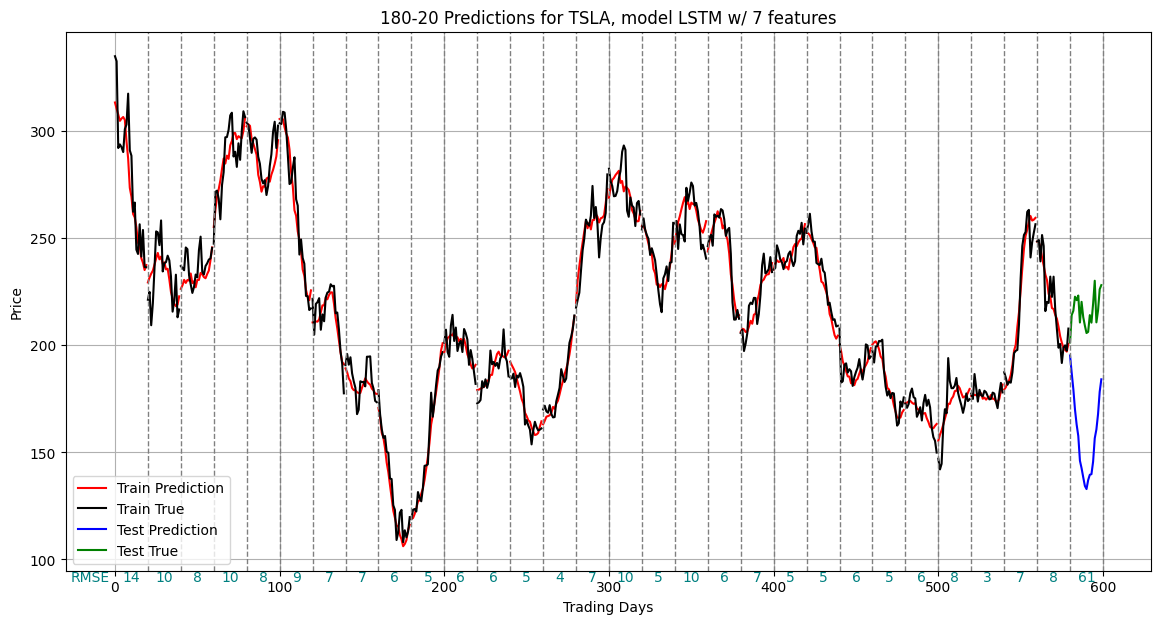

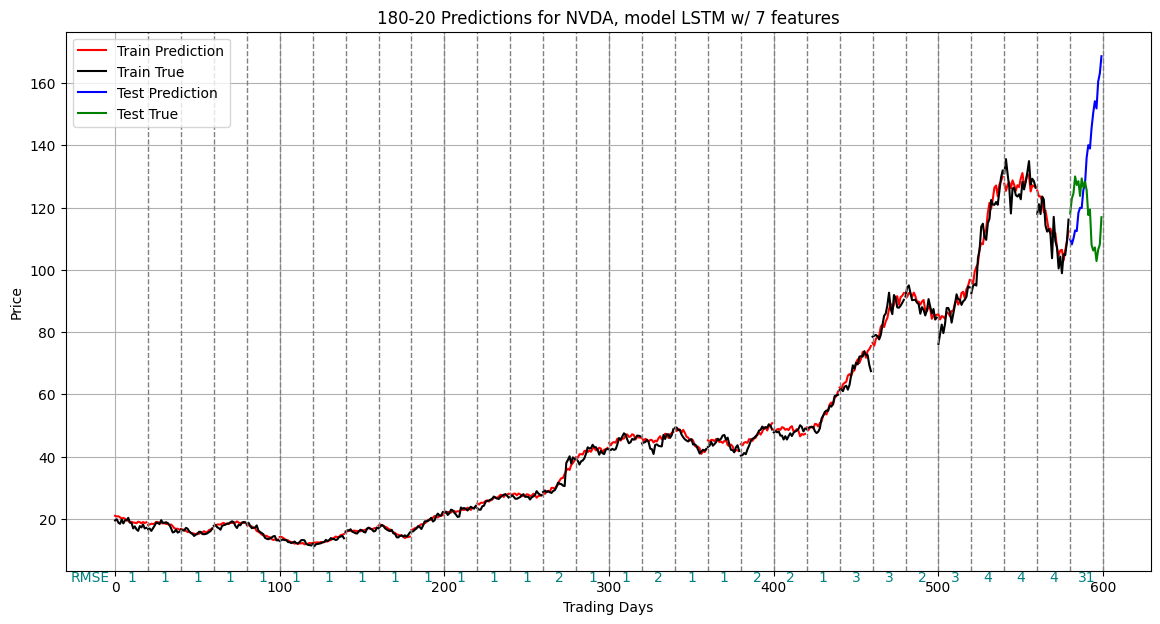

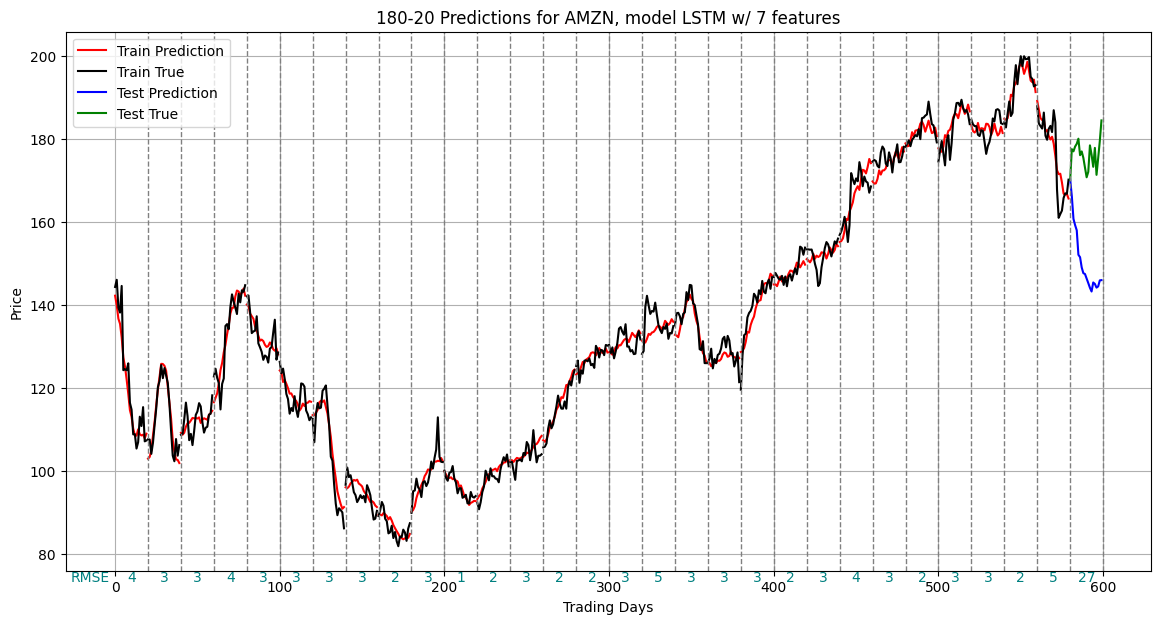

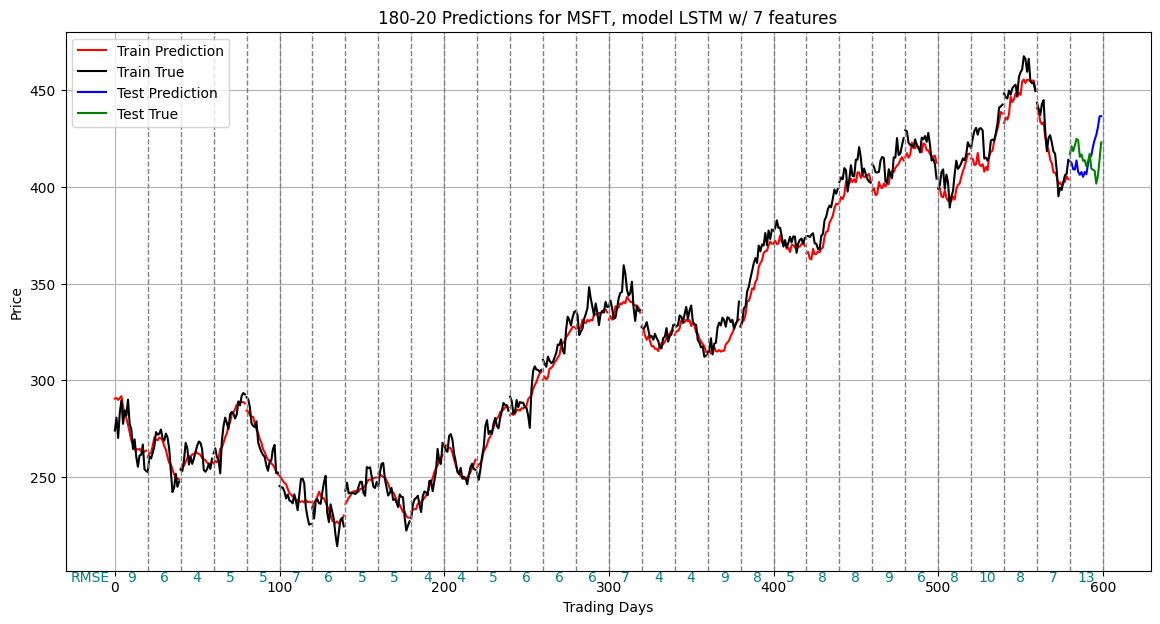

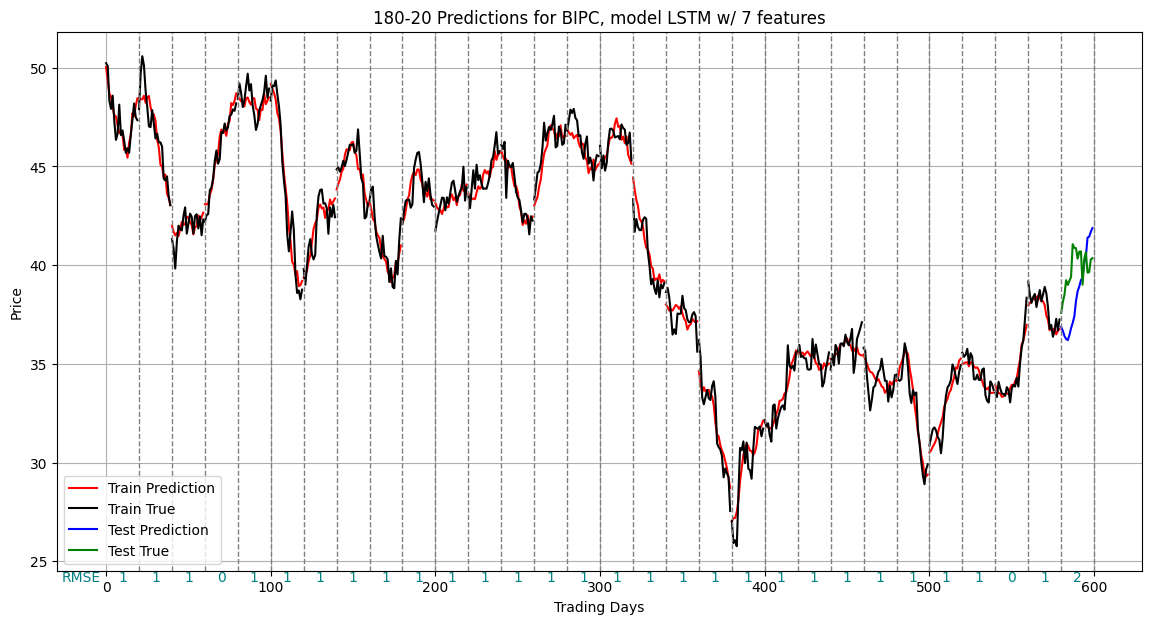

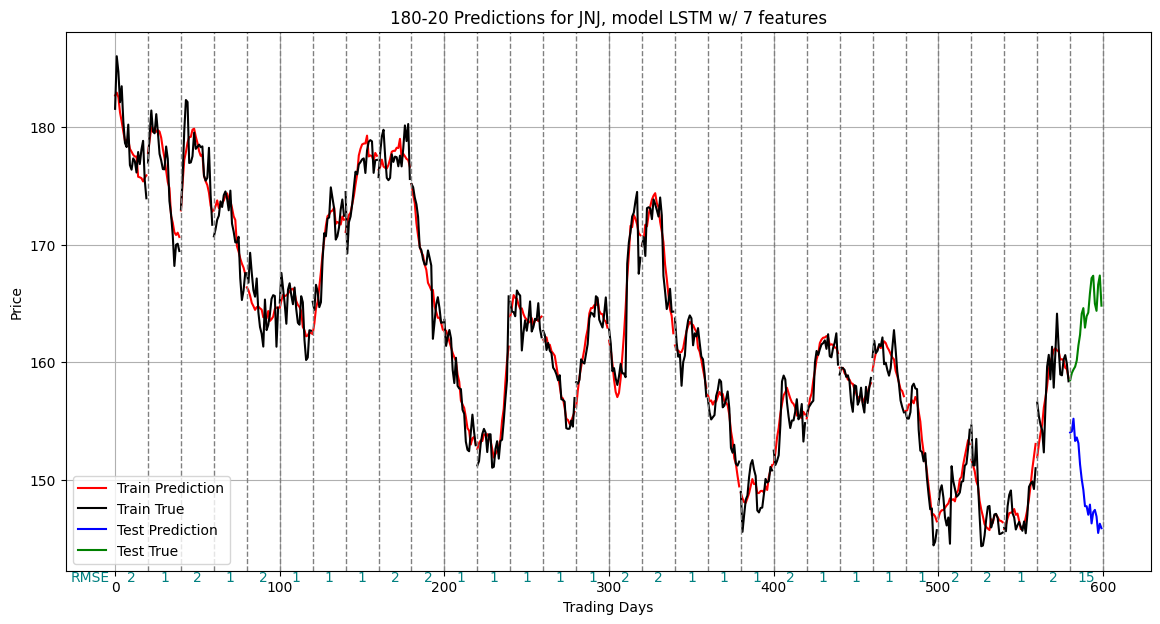

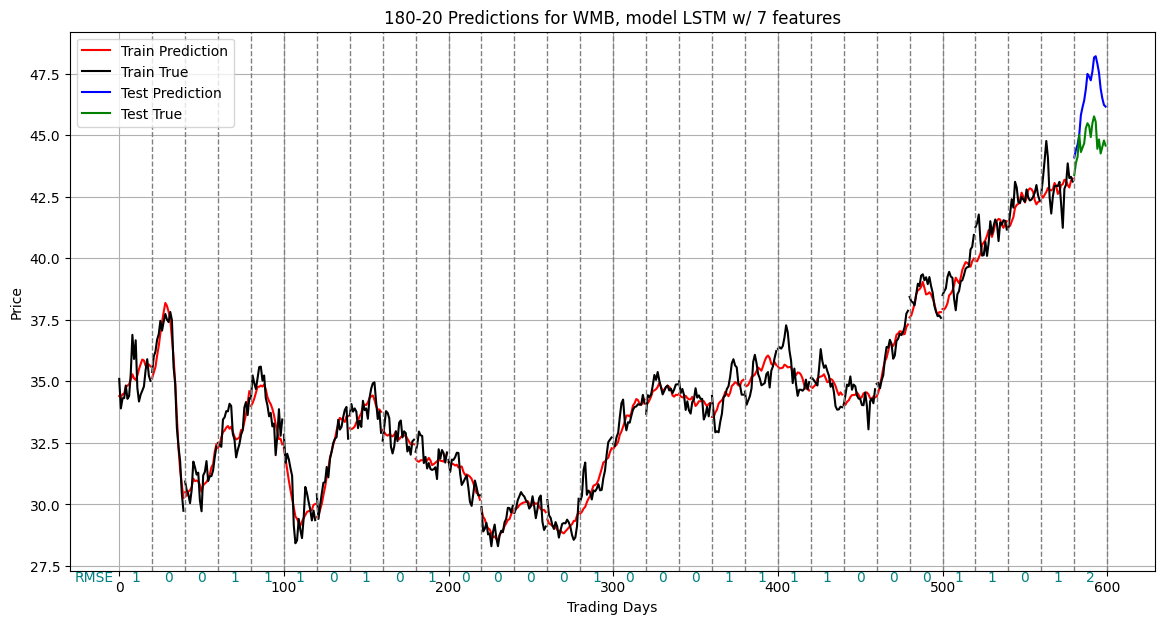

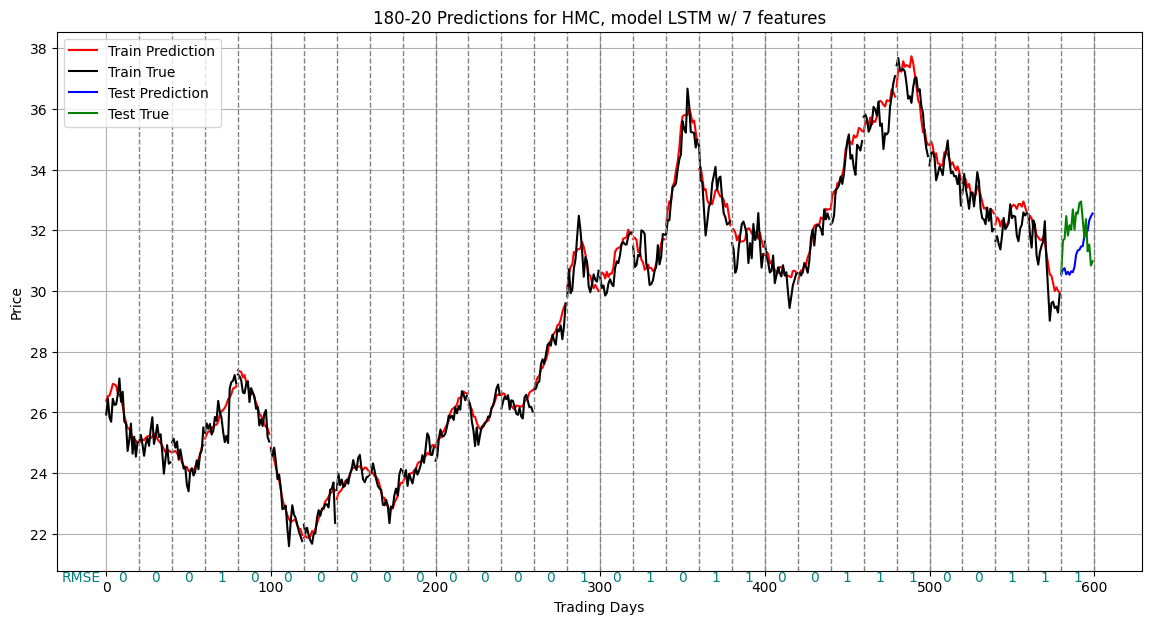

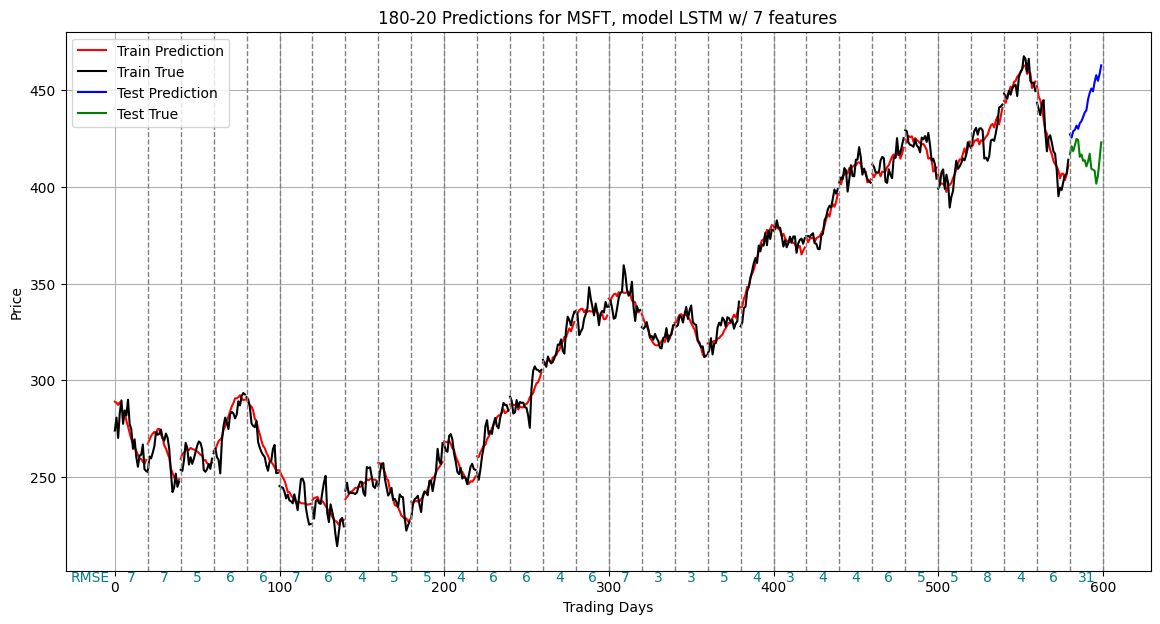

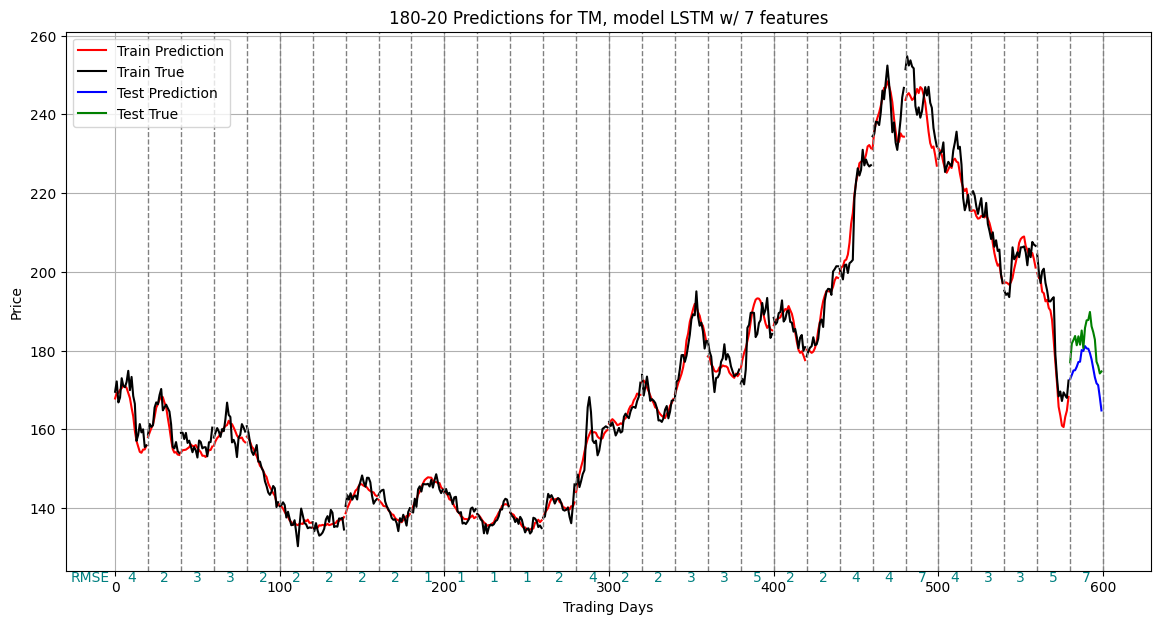

In [ ]:
tickers = ["TSLA","NVDA","AMZN","MSFT", "BIPC", "JNJ","WMB","HMC","MSFT", "TM"]
mse = main(tickers)

In [ ]:
mse


19.05406586328183